## 02. Examine the characteristics of (non-)cheaters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import analyze_cheaters
import scipy.stats

In this section, we compare cheaters and non-cheaters who played the game between March 1 and March 3. The assumption is that cheaters who were banned during this period always did cheat.<br>
The number of cheaters who were banned during this period is 651.

In [2]:
FILE_PATH = "s3://social-research-cheating/cheater-analysis/data_for_cheater_analysis.parquet"
td = spark.read.parquet(FILE_PATH)
td.registerTempTable("td")

PLAYER_DATA_PATH = "s3://social-research-cheating/players.parquet"
players = spark.read.parquet(PLAYER_DATA_PATH)
players.registerTempTable("players")

cheaters = spark.sql("SELECT * FROM players WHERE ban_date <= '2019-03-03'")
cheaters.registerTempTable("cheaters")

## 1) Calculate the average kill ratio for each cheater.

The Mean of average kill ratio is 0.77 for cheaters and the median value is 0.82.

In [3]:
kills_of_cheaters = spark.sql("""SELECT mid, src, time, m_date, ban_date 
                                 FROM td t JOIN cheaters c ON t.src = c.id""")
kills_of_cheaters.registerTempTable("kills")

deaths_of_cheaters = spark.sql("""SELECT mid, dst, time, m_date, ban_date 
                                  FROM td t JOIN cheaters c ON t.dst = c.id""")
deaths_of_cheaters.registerTempTable("deaths")

avg_kill_ratio_of_cheaters = analyze_cheaters.get_avg_kill_ratio(kills_of_cheaters, deaths_of_cheaters)

print(round(avg_kill_ratio_of_cheaters['avg_kill_ratio'].mean(), 4))
print(round(avg_kill_ratio_of_cheaters['avg_kill_ratio'].median(), 4))
print(len(avg_kill_ratio_of_cheaters['avg_kill_ratio']))

avg_kill_ratio_of_cheaters['avg_kill_ratio'] = avg_kill_ratio_of_cheaters['avg_kill_ratio'].round(4)

0.7661
0.8235
651


In [4]:
avg_kill_ratio_df = spark.createDataFrame(avg_kill_ratio_of_cheaters)
avg_kill_ratio_df.show(10)

PARQUET_PATH = "s3://social-research-cheating/cheater-analysis/avg_kill_ratio_of_cheaters.parquet"
avg_kill_ratio_df.write.parquet(PARQUET_PATH)

+--------------------+--------------+
|                  id|avg_kill_ratio|
+--------------------+--------------+
|account.002dced5b...|        0.8865|
|account.0087b5d4a...|        0.6923|
|account.00a68dddf...|        0.9205|
|account.010f30864...|        0.6667|
|account.012829a2f...|        0.8889|
|account.0198bd285...|         0.568|
|account.021034455...|           1.0|
|account.0230c074a...|        0.9146|
|account.028e1de9d...|        0.7771|
|account.036236700...|        0.3966|
+--------------------+--------------+
only showing top 10 rows



## 2) Calculate the average kill ratio for each non-cheater.

The Mean of average kill ratio is 0.4 for non-cheaters and the median value is 0.44.<br>
The number of non-cheaters who played the game between March 1 and March 3 is 854,153.

In [6]:
kills_of_non_cheaters = spark.sql("""SELECT mid, src, dst, time, m_date 
                                     FROM td t JOIN players p ON t.src = p.id 
                                     WHERE cheating_flag = 0""")
kills_of_non_cheaters.registerTempTable("kills")

deaths_of_non_cheaters = spark.sql("""SELECT mid, src, dst, time, m_date 
                                      FROM td t JOIN players p ON t.dst = p.id 
                                      WHERE cheating_flag = 0""")
deaths_of_non_cheaters.registerTempTable("deaths")

avg_kill_ratio_of_non_cheaters = analyze_cheaters.get_avg_kill_ratio(kills_of_non_cheaters, deaths_of_non_cheaters)

print(round(avg_kill_ratio_of_non_cheaters['avg_kill_ratio'].mean(), 4))
print(round(avg_kill_ratio_of_non_cheaters['avg_kill_ratio'].median(), 4))
print(len(avg_kill_ratio_of_non_cheaters['avg_kill_ratio']))

avg_kill_ratio_of_non_cheaters['avg_kill_ratio'] = avg_kill_ratio_of_non_cheaters['avg_kill_ratio'].round(4)

0.4045
0.4437
854153


In [7]:
avg_kill_ratio_df = spark.createDataFrame(avg_kill_ratio_of_non_cheaters)
avg_kill_ratio_df.show(10)

PARQUET_PATH = "s3://social-research-cheating/cheater-analysis/avg_kill_ratio_of_non_cheaters.parquet"
avg_kill_ratio_df.write.parquet(PARQUET_PATH)

+--------------------+--------------+
|                  id|avg_kill_ratio|
+--------------------+--------------+
|account.0000074ae...|        0.5675|
|account.000033c3d...|        0.5385|
|account.000046d1e...|           0.3|
|account.00006cfdb...|         0.875|
|account.000078418...|          0.25|
|account.00007c1e6...|           0.0|
|account.0000bd144...|        0.5152|
|account.0000c5a5c...|        0.5227|
|account.0000cd816...|        0.3585|
|account.0000f03a4...|           0.0|
+--------------------+--------------+
only showing top 10 rows



## 3) Plot the histogram of average kill ratio for both cheaters and non-cheaters.

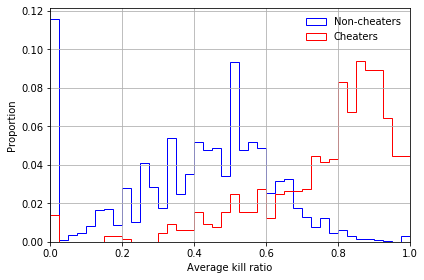

In [3]:
avg_kill_ratio_of_cheaters = pd.read_csv("data/cheater_analysis/c_avg_kill_ratio.csv")
avg_kill_ratio_of_non_cheaters = pd.read_csv("data/cheater_analysis/nc_avg_kill_ratio.csv")

ax = avg_kill_ratio_of_non_cheaters.hist(column='avg_kill_ratio', histtype='step', edgecolor='blue', 
                                         bins=40, label='Non-cheaters', 
                                         weights=np.zeros_like(avg_kill_ratio_of_non_cheaters['avg_kill_ratio']) + 1. / 
                                         len(avg_kill_ratio_of_non_cheaters['avg_kill_ratio']))
fig = avg_kill_ratio_of_cheaters.hist(column='avg_kill_ratio', histtype='step', edgecolor='red', 
                                      bins=40, label='Cheaters', 
                                      weights=np.zeros_like(avg_kill_ratio_of_cheaters['avg_kill_ratio']) + 1. / 
                                      len(avg_kill_ratio_of_cheaters['avg_kill_ratio']), ax=ax)
plt.title("")
plt.xlim(xmin=0)
plt.xlim(xmax=1)
plt.xlabel('Average kill ratio')
plt.ylabel('Proportion')
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
plt.show()

## 4) Calculate the average time difference between consecutive kills for each cheater.

In [9]:
kills_of_cheaters.registerTempTable("kills")
avg_kill_interval_of_cheaters = analyze_cheaters.get_avg_time_diff_between_kills(kills_of_cheaters)

print(round(avg_kill_interval_of_cheaters['delta'].mean(), 4))
print(round(avg_kill_interval_of_cheaters['delta'].median(), 4))
print(len(avg_kill_interval_of_cheaters['delta']))

avg_kill_interval_of_cheaters['delta'] = avg_kill_interval_of_cheaters['delta'].round(4)

139.6698
123.9302
629


In [10]:
avg_kill_interval_of_cheaters_df = spark.createDataFrame(avg_kill_interval_of_cheaters)
avg_kill_interval_of_cheaters_df.show(10)

PARQUET_PATH = "s3://social-research-cheating/cheater-analysis/avg_kill_interval_of_cheaters.parquet"
avg_kill_interval_of_cheaters_df.write.parquet(PARQUET_PATH)

+--------------------+--------+
|                  id|   delta|
+--------------------+--------+
|account.ba9810e0f...|201.2667|
|account.61973e29f...|251.6154|
|account.8d69e3520...| 98.1818|
|account.bcb700986...|184.1081|
|account.dc0d711ba...|127.3571|
|account.feec603d5...| 60.3797|
|account.11dbd81ee...|101.2308|
|account.1c4cf8633...|301.8333|
|account.a98a65311...| 267.875|
|account.da1a6fa0b...|168.3611|
+--------------------+--------+
only showing top 10 rows



## 5) Calculate the average time difference between consecutive kills for each non-cheater.

In [11]:
kills_of_non_cheaters.registerTempTable("kills")
avg_kill_interval_of_non_cheaters = analyze_cheaters.get_avg_time_diff_between_kills(kills_of_non_cheaters)

print(round(avg_kill_interval_of_non_cheaters['delta'].mean(), 4))
print(round(avg_kill_interval_of_non_cheaters['delta'].median(), 4))
print(len(avg_kill_interval_of_non_cheaters['delta']))

avg_kill_interval_of_non_cheaters['delta'] = avg_kill_interval_of_non_cheaters['delta'].round(4)

194.109
172.6348
623678


In [12]:
avg_kill_interval_of_non_cheaters_df = spark.createDataFrame(avg_kill_interval_of_non_cheaters)
avg_kill_interval_of_non_cheaters_df.show(10)

PARQUET_PATH = "s3://social-research-cheating/cheater-analysis/avg_kill_interval_of_non_cheaters.parquet"
avg_kill_interval_of_non_cheaters_df.write.parquet(PARQUET_PATH)

+--------------------+--------+
|                  id|   delta|
+--------------------+--------+
|account.03c232145...|166.8333|
|account.040e883a9...|302.1538|
|account.041032a10...|    47.0|
|account.04273703d...|   122.8|
|account.045b6902a...|   121.6|
|account.045d649ca...|262.1111|
|account.04779d220...|   185.2|
|account.049157afd...|    36.0|
|account.04965c2d9...|     0.0|
|account.04b32dcb0...|   204.8|
+--------------------+--------+
only showing top 10 rows



## 6) Plot the histogram of average time difference between kills for both cheaters and non-cheaters.

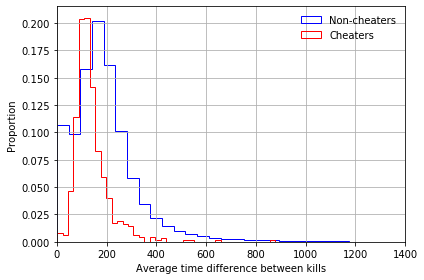

In [4]:
avg_kill_interval_of_cheaters = pd.read_csv("data/cheater_analysis/c_avg_kill_interval.csv")
avg_kill_interval_of_non_cheaters = pd.read_csv("data/cheater_analysis/nc_avg_kill_interval.csv")

ax = avg_kill_interval_of_non_cheaters.hist(column='delta', histtype='step', edgecolor='blue', 
                                            bins=40, label='Non-cheaters', 
                                            weights=np.zeros_like(avg_kill_interval_of_non_cheaters['delta']) + 1. / 
                                            len(avg_kill_interval_of_non_cheaters['delta']))
fig = avg_kill_interval_of_cheaters.hist(column='delta', histtype='step', edgecolor='red', 
                                         bins=40, label='Cheaters', 
                                         weights=np.zeros_like(avg_kill_interval_of_cheaters['delta']) + 1. / 
                                         len(avg_kill_interval_of_cheaters['delta']), ax=ax)
plt.title("")
plt.xlabel('Average time difference between kills')
plt.ylabel('Proportion')
plt.xlim(xmin=0)
plt.xlim(xmax=1400)  # Exclude outliers.
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

## 7) Perform t-tests.

The difference in the average kill ratio between the two groups is significant, t=48.64, p<0.01.
There is also a significant difference in the average time difference between consecutive kills, t=-18.24, p<0.01. 

In [13]:
print(scipy.stats.ttest_ind(avg_kill_ratio_of_cheaters['avg_kill_ratio'], 
                            avg_kill_ratio_of_non_cheaters['avg_kill_ratio'], 
                            equal_var=False))

print(scipy.stats.ttest_ind(avg_kill_interval_of_cheaters['delta'], 
                            avg_kill_interval_of_non_cheaters['delta'], 
                            equal_var=False))

Ttest_indResult(statistic=48.64290196560924, pvalue=5.2129993985436896e-219)
Ttest_indResult(statistic=-18.235341545750604, pvalue=5.033833786064087e-60)
